In [2]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


In [4]:
from IPython.display import HTML
style = "<style>svg{width: 100% !important; height: 100% !important;} </style>"
HTML(style)

In [5]:
titanic_data = pd.read_csv('train.csv')
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Создаем DF с исходными данными по пассажирам,
исключив несущественные колонки.
И DF с известными исходами по этим же пассажирам

In [6]:
X = titanic_data.drop(['PassengerId','Survived',
                       'Name','Cabin','Ticket'], axis=1)
y = titanic_data.Survived

In [7]:
# применяем однострочное кодирование для
# номинативных переменных
X = pd.get_dummies(X)

In [8]:
# Заполняем пропуски в столбце с возрастом
# на медианные значения
X = X.fillna({'Age': X.Age.median()})

In [9]:
# Проверяем, что в DF не осталось пропущенных значений
X.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

Создаём классификатор "Дерево решений"
и обучаем его на ранее сформированных данных

In [10]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy')

Рисуем получившееся дерево решений.
(видим, что решили не совсем нужную задачу)

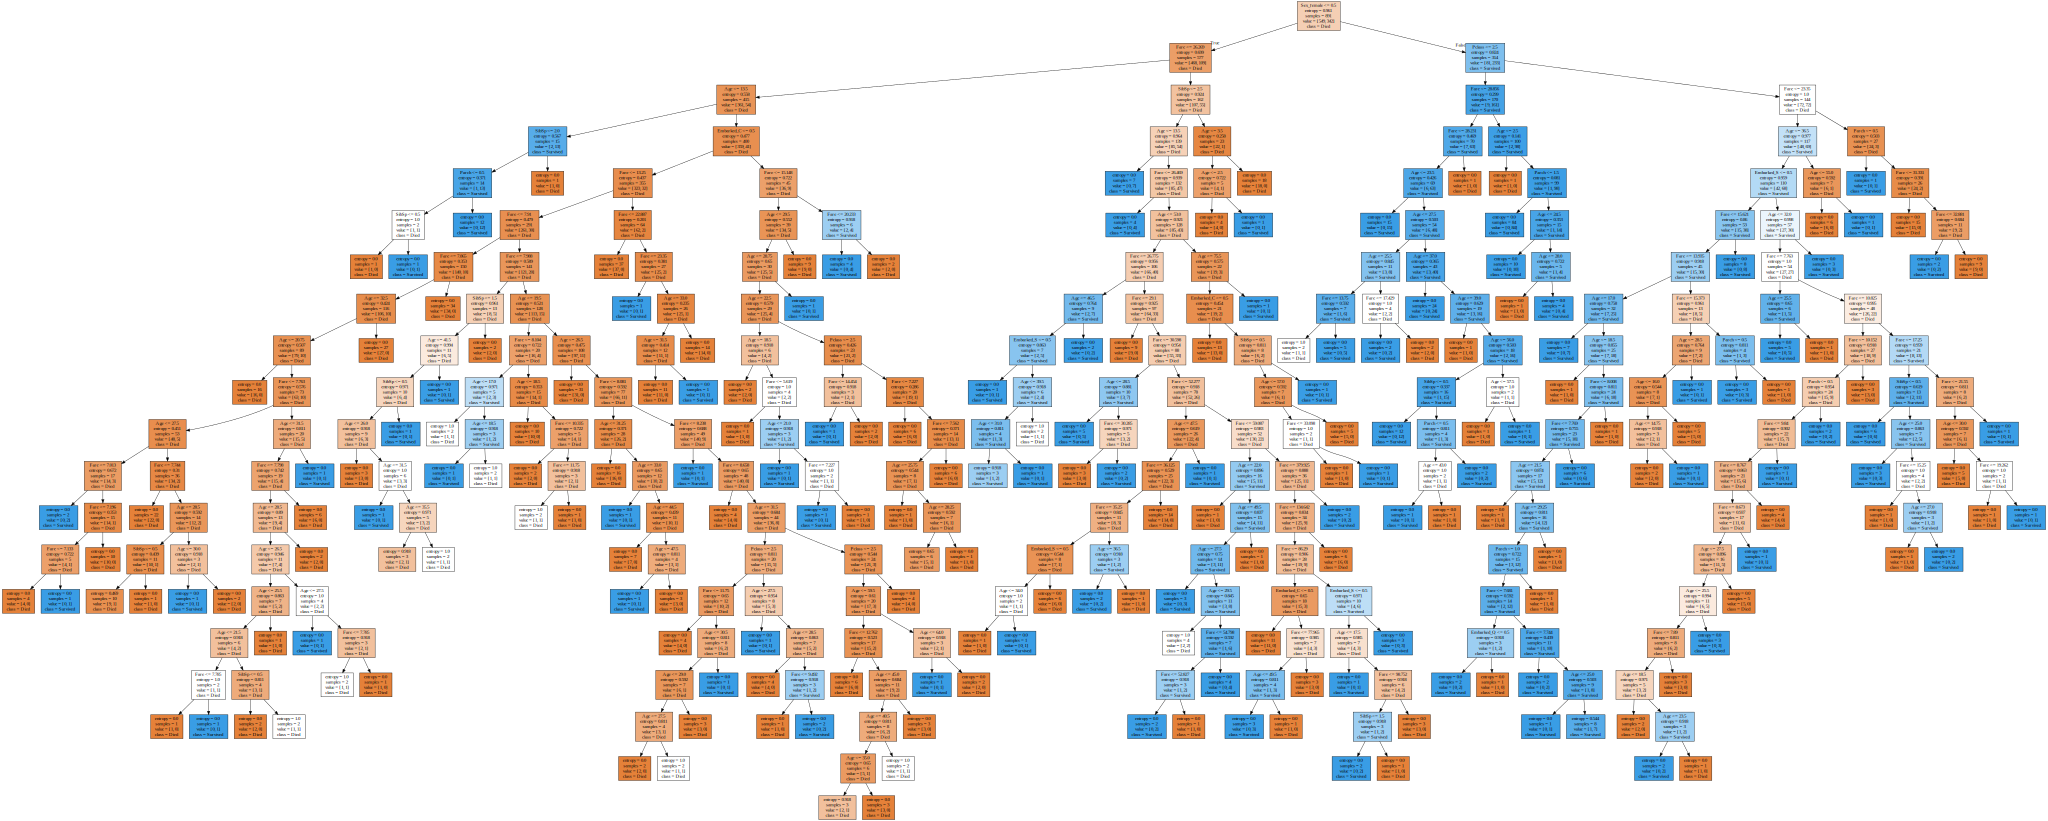

In [11]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                    feature_names=list(X),
                                    class_names=['Died',
                                                 'Survived'],
                                    filled=True))

display(SVG(graph.pipe(format='svg')))

Разбиваем наши полные DF на два множества в соотношении 2:1:
1. для обучения модели
2. для её тестирования

In [12]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.33,
                           random_state = 42)

In [13]:
# Оцениваем качество модели на полном DF
clf.score(X,y)

0.9797979797979798

In [14]:
# Обучаем модель на тренировочном подмножестве
# и проверяем качество модели на нём же
clf.fit(X_train,y_train)
clf.score(X_train,y_train)

0.9798657718120806

In [15]:
# и проверяем качество модели на тестовых подмножествах
clf.score(X_test, y_test)

0.7593220338983051

1. Создаём новое дерево решений, указав его глубину
2. Обучаем на тренировочных подмножествах

In [16]:
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_depth=3)
clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

Оцениваем качество моделей


In [17]:
clf.score(X_train,y_train)


0.8238255033557047

In [18]:
clf.score(X_test, y_test)


0.8203389830508474

Соберём статистику о качестве моделей для разной глубины.
При этом применим кроссвалидацию, чтобы избежать переобучения модели

In [19]:
max_depth_values = range(1,50)
scores_data = pd.DataFrame()

In [20]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy',
                                      max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    mean_cross_val_score = cross_val_score(clf,
                                           X_train,
                                           y_train,
                                           cv=5).mean()

    temp_score_data = \
    pd.DataFrame({'max_depth': [max_depth],
                  'train_score': [train_score],
                  'test_score': [test_score],
                  'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

In [21]:
scores_data.head()


,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.810169,0.795350


In [22]:
scores_data_long = pd.melt(scores_data,
                id_vars=['max_depth'],
                value_vars=['train_score','test_score', 'cross_val_score'],
                var_name='set_type',
                value_name='score')

In [23]:
scores_data_long

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604
...,...,...,...
142,45,cross_val_score,0.768487
143,46,cross_val_score,0.765140
144,47,cross_val_score,0.771863
145,48,cross_val_score,0.760098


Построим график качества моделей для разных подмножеств данных
в зависимости от глубины. (Видим, что для кроссвалидных данных
наилучшие результаты на отрезке от 5 до 10)


<AxesSubplot:xlabel='max_depth', ylabel='score'>

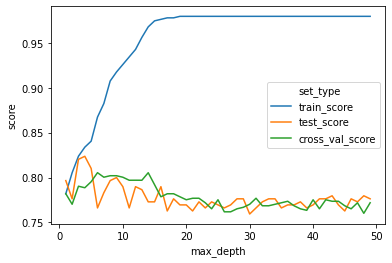

In [24]:
sns.lineplot(x="max_depth",
             y="score",
             hue="set_type",
             data=scores_data_long)

In [25]:
scores_data_long.query("set_type == 'cross_val_score'").head(20)


,max_depth,set_type,score
98,1,cross_val_score,0.781961
99,2,cross_val_score,0.770196
100,3,cross_val_score,0.790322
101,4,cross_val_score,0.788627
102,5,cross_val_score,0.795350
103,6,cross_val_score,0.805434
104,7,cross_val_score,0.800378
105,8,cross_val_score,0.802045
106,9,cross_val_score,0.802031
107,10,cross_val_score,0.800350


Возьмём из таблицы глубину для крроссвалидного теста
с наилучшим показателем и построим уже окончательную модель

In [26]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                      max_depth=8)
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [27]:
best_clf.score(X_test, y_test)


0.8

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
clf = tree.DecisionTreeClassifier()


In [30]:
parametrs = {'criterion':['gini','entropy'], 'max_depth':range(1,30)}

In [31]:
grid_search_cv_clf = GridSearchCV(clf, parametrs,cv=5)


In [32]:
grid_search_cv_clf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [33]:
grid_search_cv_clf.best_params_


{'criterion': 'entropy', 'max_depth': 6}

In [34]:
best_clf = grid_search_cv_clf.best_estimator_

In [35]:
best_clf.score(X_test,y_test)


0.7661016949152543

In [36]:
from sklearn.metrics import precision_score, recall_score


In [37]:
y_pred = best_clf.predict(X_test)

In [38]:
precision_score(y_test,y_pred)


0.7931034482758621

In [39]:
recall_score(y_test,y_pred)


0.575

In [40]:
y_predicted_prob = best_clf.predict_proba(X_test)

In [41]:
# y_predicted_prob

<AxesSubplot:>

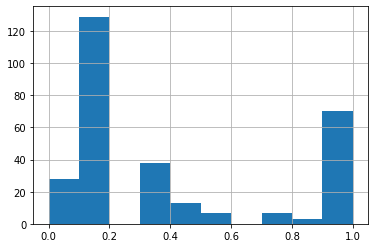

In [42]:
pd.Series(y_predicted_prob[:,1]).hist()

In [43]:
y_pred = np.where(y_predicted_prob[:,1] > 0.8, 1, 0)

In [44]:
precision_score(y_test,y_pred)


0.8493150684931506

In [45]:
recall_score(y_test,y_pred)


0.5166666666666667

In [45]:
####################################################

In [53]:
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_depth=3,
                                  min_samples_split=100,
                                  min_samples_leaf=10)

In [54]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10,
                       min_samples_split=100)

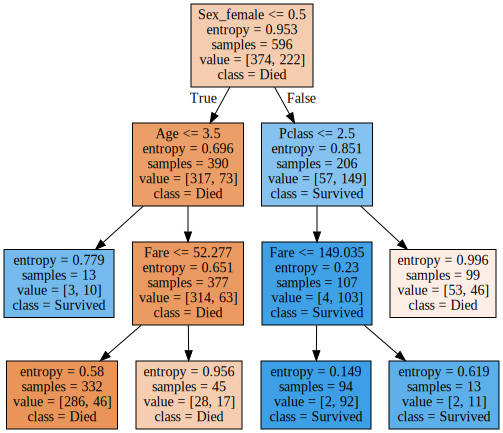

In [55]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X),
                                   class_names=['Died', 'Survived'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
clf_rf = RandomForestClassifier()
parametrs = {'n_estimators': [10,20,30], 'max_depth': [2,5,7,10]}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)

In [58]:
grid_search_cv_clf.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 20, 30]})

In [59]:
grid_search_cv_clf.best_params_

{'max_depth': 5, 'n_estimators': 30}

In [60]:
best_clf = grid_search_cv_clf.best_estimator_


In [61]:
best_clf.score(X_test, y_test)

0.8169491525423729

In [63]:
feature_importances = best_clf.feature_importances_

In [64]:
feature_importances_df = pd.DataFrame({'feature':X_train.columns,
                                       'feature_importances':feature_importances})

In [69]:
feature_importances_df.sort_values('feature_importances',
                                   ascending=False)

,feature,feature_importances
6,Sex_male,0.250394
5,Sex_female,0.235904
4,Fare,0.138286
0,Pclass,0.114488
1,Age,0.113228
3,Parch,0.044952
2,SibSp,0.044713
7,Embarked_C,0.027961
9,Embarked_S,0.016880
8,Embarked_Q,0.013196
